In [2]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report,f1_score
import preprocessor as p
import gensim
import gensim.downloader as gensim_api

In [3]:
#!pip install -U wordcloud
#!pip install -U plotly plotly-express
#!pip install -U spacy
## for word embedding
#!pip install -U gensim
#!pip install tweet-preprocessor
# nlp = spacy.load('en_core_web_sm')
import nltk
# nltk.download('wordnet')

In [4]:
# Importing the training dataset
DATASET_COLUMNS=['id','label','tweet']
df_train = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/train_E6oV3lV.csv', names=DATASET_COLUMNS, header=0)
df_train.sample(5)

,id,label,tweet
29170,29171,0,#samsunggalaxys2 rooster simulation: i want ...
26422,26423,0,i hate it when a youtuber does a giveaway. it ...
18947,18948,0,we're absolutely thrilled to be marching right...
3139,3140,0,thats right !! #wedding #pay #weddingpay #bi #...
8085,8086,0,@user cookies. protein. fun! #lennyandlarrys ...


In [5]:
#Length of the dataset

print('length of train data is', len(df_train))
df_train.describe()

length of train data is 31962


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
# Importing the Testing dataset
DATASET_COLUMNS=['id','tweet']
df_test = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/test_tweets_anuFYb8.csv', names=DATASET_COLUMNS,header=0)
df_test.sample(5)

,id,tweet
4791,36754,@user @user love you brother
4172,36135,have my lover stop being angry at me visit us....
13326,45289,@user i'm guessing that they're insecure and i...
15076,47039,@user butterfly - lives to fly another day....
5283,37246,"happy dappy bihday, mr. viking! ðð» #b..."


In [7]:
#Length of the dataset

print('length of test data is', len(df_test))

length of test data is 17197


In [8]:
#Check the number of target values
df_train['label'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='label', ylabel='count'>

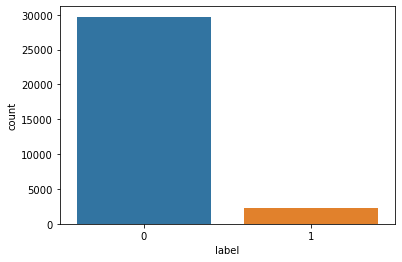

In [9]:
# Plotting the distribution for dataset.
#px.box(df_train, x="label", y="tweet", color="label", title="Distribution of tweets for each label")
sns.countplot(x='label', data=df_train)
# Storing data in lists.
#text, sentiment = list(df_train['tweet']), list(df_train['label'])

In [10]:
fig = px.pie(df_train, names=df_train.label, hole=0.7, title='Tweets Classification',
             height=250, color_discrete_sequence=px.colors.qualitative.T10)
fig.update_layout(margin=dict(t=100, b=40, l=60, r=40), 
                  plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                  title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  )
fig.show()

#### Word Count per Label

In [11]:
df_train['word_counts'] = df_train['tweet'].str.split().str.len()
df_train.groupby('label')['word_counts'].mean()

label
0    13.091252
1    14.053078
Name: word_counts, dtype: float64

## Data Preprocesing

In [12]:
lst_stopwords = stopwords.words("english")
lst_stopwords
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    """

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def remove_pattern(input_txt):
    r = re.findall(r"@(\w+)", input_txt)
    for i in r:
        input_txt = re.sub(f'@{i}', '', input_txt)      
    return input_txt
    
def preprocess_tweet(row):
    text = row['clean_tweet1']
    text = p.clean(text)
    return text

def preprocessing_text(text):
     # Make lowercase
     text = text.str.lower()
     # Remove punctuation
     text = text.str.replace('[^\w\s]', '', regex=True)
     # Remove digits
     text = text.str.replace('[\d]+', '', regex=True)
     return text
pd.set_option('max_colwidth', 500)

In [13]:
# Remove @user from the twwet
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: remove_pattern(x))
df_train['clean_tweet1'] = df_train["tweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df_train['clean_tweet1'] = df_train.apply(preprocess_tweet, axis=1)
df_train['clean_tweet1'] = preprocessing_text(df_train['clean_tweet1'])
df_train.tail()

,id,label,tweet,word_counts,clean_tweet,clean_tweet1
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸,5,ate isz that youuu?ðððððððððâ¤ï¸,ate user isz youuu
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,23,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,see nina turner airwave trying wrap mantle genuine hero like shirley chisolm shame imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad,13,listening to sad songs on a monday morning otw to work is sad,listening sad song monday morning otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act",10,"#sikh #temple vandalised in in #calgary, #wso condemns act",user sikh temple vandalised calgary wso condemns act
31961,31962,0,thank you @user for you follow,6,thank you for you follow,thank user follow


In [14]:
#remove_pattern('@user when a father is dysfunctional and his son is a good')
df_train['tweet'][df_train['label'] == 0][:10]

0                                              @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1                         @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2                                                                                                                                bihday your majesty
3                                                             #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4                                                                                                             factsguide: society now    #motivation
5                               [2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
6                                                                          @user camping tomorrow @user @u

In [15]:
df_train.head()

,id,label,tweet,word_counts,clean_tweet,clean_tweet1
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,18,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,user father dysfunctional selfish drag kid dysfunction run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,19,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,user user thanks lyft credit cant use cause dont offer wheelchair van pdx disapointed getthanked
2,3,0,bihday your majesty,3,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,14,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur
4,5,0,factsguide: society now #motivation,4,factsguide: society now #motivation,factsguide society motivation


In [16]:
hashtags = []
def hashtag_extract(x):
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from neg/pos tweets
dff_0 = hashtag_extract(df_train['clean_tweet'][df_train['label'] == 0])
dff_1 = hashtag_extract(df_train['clean_tweet'][df_train['label'] == 1])
dff_all = hashtag_extract(df_train['clean_tweet'][df_train['label']])
# unnesting list
dff_0 = sum(dff_0,[])
dff_1 = sum(dff_1,[])
dff_all = sum(dff_all,[])

data_0 = FreqDist(dff_0)
data_0 = pd.DataFrame({'Hashtag': list(data_0.keys()),
                  'Count': list(data_0.values())}).sort_values(by='Count', ascending=False)

In [17]:
data_0[:10]

,Hashtag,Count
0,run,29753
3,getthanked,2244
1,lyft,2244
2,disapointed,2243
33,love,1542
41,positive,874
163,healthy,571
212,smile,548
40,thankful,491
183,fun,434


<AxesSubplot:xlabel='Count', ylabel='Hashtag'>

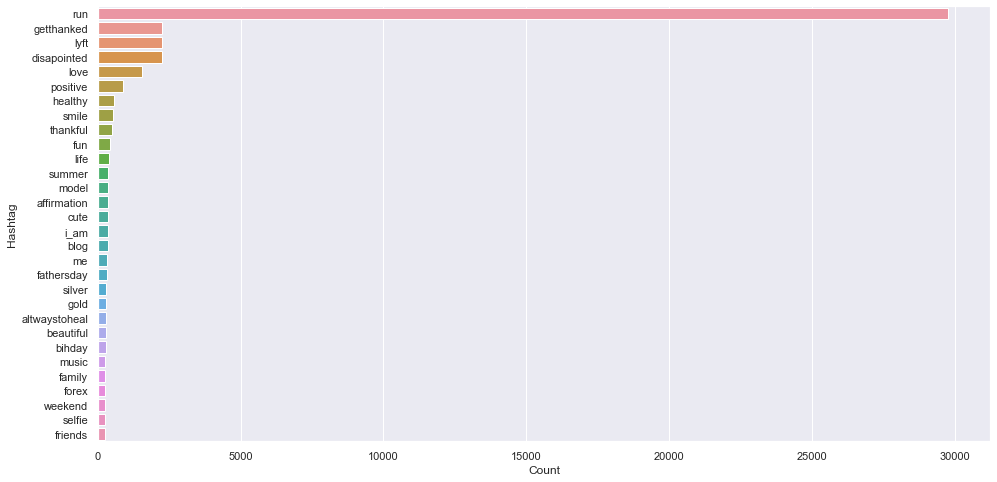

In [18]:
# fig = px.bar(data_0[:30], x='Hashtag', y='Count', height=250,
#              title='Top 30 hashtags',
#              color_discrete_sequence=px.colors.qualitative.T10)
# fig.update_yaxes(showgrid=False),
# fig.update_xaxes(categoryorder='total descending')
# fig.update_traces(hovertemplate=None)
# fig.update_layout(margin=dict(t=100, b=0, l=60, r=40), 
#                   hovermode="x unified",
#                   xaxis_tickangle=300,
#                   xaxis_title=' ', yaxis_title=" ",
#                   plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
#                   title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
#                   font=dict(color='#8a8d93')
#                   )
# fig.show()
sns.set(rc={'figure.figsize':(16,8)})
sns.barplot(y=data_0['Hashtag'][:30], x=data_0['Count'][:30])

In [19]:
# # Removing Stopwords
# STOPWORDS = stopwords.words('english')

# def cleaning_stopwords(text,STOPWORDS):
#     return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda text: cleaning_stopwords(text,STOPWORDS))
# df_train['clean_tweet'].head()

In [20]:
a = df_train['clean_tweet1'].str.cat(sep=' ')
words = word_tokenize(a)
word_dist = FreqDist(words)
dff = pd.DataFrame(word_dist.most_common(), 
                    columns=['Word', 'Frequency'])
dff['Word_Count'] = dff.Word.apply(len)
dff[:5]

,Word,Frequency,Word_Count
0,user,17500,4
1,love,2774,4
2,day,2768,3
3,happy,1691,5
4,u,1657,1


<AxesSubplot:xlabel='Frequency', ylabel='Word'>

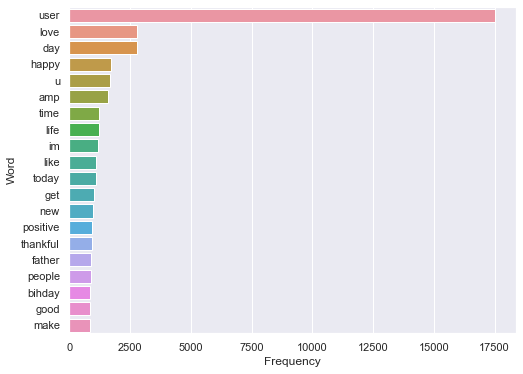

In [21]:
# fig = px.histogram(dff[:20], x='Word', y='Frequency', height=300, 
#                    title='Most common 20 words in tweets', color_discrete_sequence=px.colors.qualitative.T10)
# fig.update_yaxes(showgrid=False),
# fig.update_xaxes(categoryorder='total descending')
# fig.update_traces(hovertemplate=None)
# fig.update_layout(margin=dict(t=100, b=0, l=70, r=40),
#                         hovermode="x unified",
#                         xaxis_tickangle=360,
#                         xaxis_title=' ', yaxis_title=" ",
#                         plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
#                         title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
#                         font=dict(color='#8a8d93'),
#                           )
# fig.show()
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(y=dff['Word'][:20], x=dff['Frequency'][:20])

<AxesSubplot:xlabel='Frequency', ylabel='Word'>

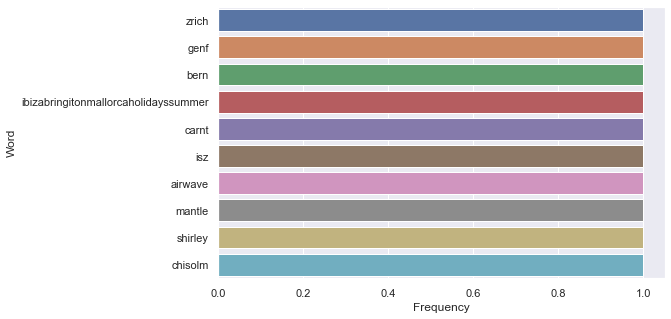

In [22]:
# fig = px.bar(dff.tail(10), x='Word', y='Frequency', height=300, 
#                    title='Least common 10 words in tweets', color_discrete_sequence=px.colors.qualitative.T10)
# fig.update_yaxes(showgrid=False),
# fig.update_xaxes(categoryorder='total descending')
# fig.update_traces(hovertemplate=None)
# fig.update_layout(margin=dict(t=100, b=0, l=70, r=40),
#                         hovermode="x unified",
#                         xaxis_title=' ', yaxis_title=" ",
#                         plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
#                         title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
#                         font=dict(color='#8a8d93'),
#                           )
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(y=dff['Word'].tail(10), x=dff['Frequency'].tail(10))

In [23]:
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag,download
from collections import Counter
tokenizer = RegexpTokenizer(r'\w+')
df_train['token_tweet'] = df_train['clean_tweet1'].apply(tokenizer.tokenize)
df_train['postag_tweet'] = df_train['token_tweet'].apply(lambda x: pos_tag(x))


In [24]:
counts = Counter( tag for df_train['token_tweet'].iloc[1],  tag in df_train['postag_tweet'].iloc[1])
print(counts,df_train['tweet'].iloc[1])
df_train.head()

Counter({'NN': 8, 'VBP': 2, 'VBD': 2, 'RB': 1, 'JJ': 1, 'NNS': 1}) @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,label,tweet,word_counts,clean_tweet,clean_tweet1,token_tweet,postag_tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,18,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,user father dysfunctional selfish drag kid dysfunction run,"[user, father, dysfunctional, selfish, drag, kid, dysfunction, run]","[(user, NN), (father, RBR), (dysfunctional, JJ), (selfish, JJ), (drag, NN), (kid, NN), (dysfunction, NN), (run, VB)]"
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,19,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,user user thanks lyft credit cant use cause dont offer wheelchair van pdx disapointed getthanked,getthanked,"[(user, RB), (user, JJ), (thanks, NNS), (lyft, VBP), (credit, NN), (cant, NN), (use, NN), (cause, NN), (dont, NN), (offer, VBP), (wheelchair, NN), (van, NN), (pdx, NN), (disapointed, VBD), (getthanked, VBD)]"
2,3,0,bihday your majesty,3,bihday your majesty,bihday majesty,"[bihday, majesty]","[(bihday, NN), (majesty, NN)]"
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,14,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur,"[model, love, u, take, u, time, ur]","[(model, NN), (love, NN), (u, JJ), (take, VB), (u, JJ), (time, NN), (ur, JJ)]"
4,5,0,factsguide: society now #motivation,4,factsguide: society now #motivation,factsguide society motivation,"[factsguide, society, motivation]","[(factsguide, RB), (society, NN), (motivation, NN)]"


#### Words in overall tweets

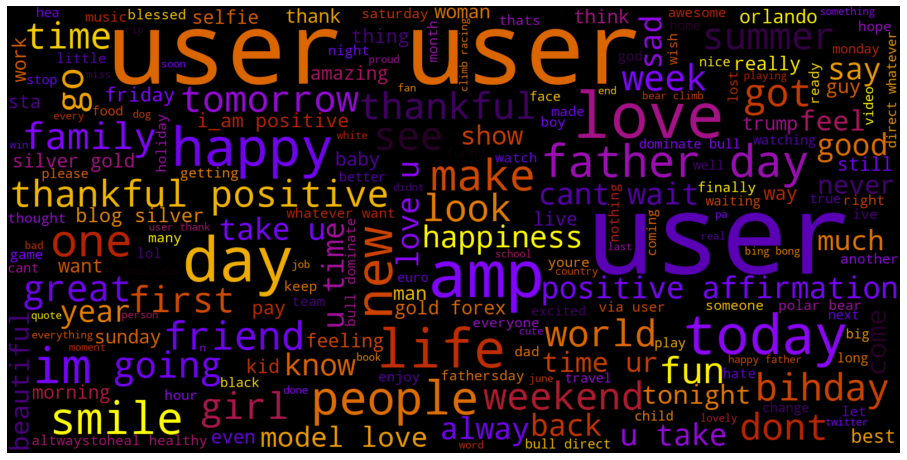

In [25]:
neg_string = []
for t in df_train.clean_tweet1:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap="gnuplot").generate(neg_string)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### “Words in non racist/sexist tweets”

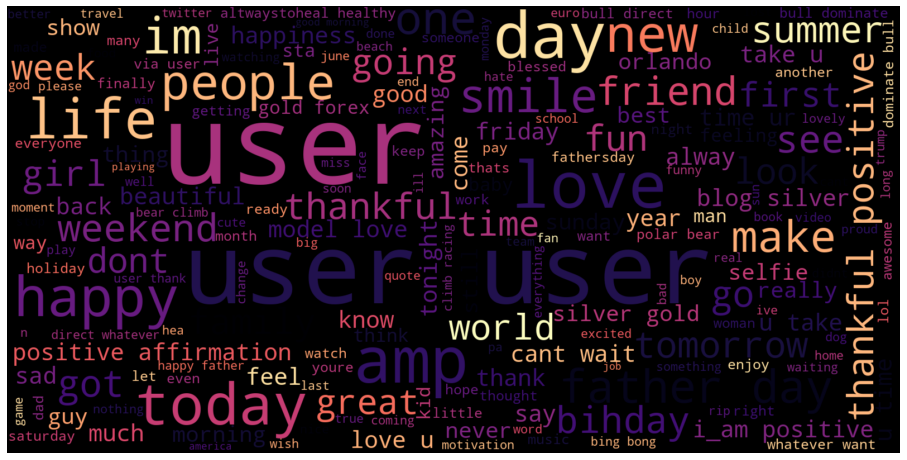

In [26]:
#“Words in non racist/sexist tweets”
neg_tweets = df_train[df_train['label'] == 0]
neg_string = []
for t in neg_tweets.clean_tweet1:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap="magma").generate(neg_string)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### “Words in racist/sexist tweets”

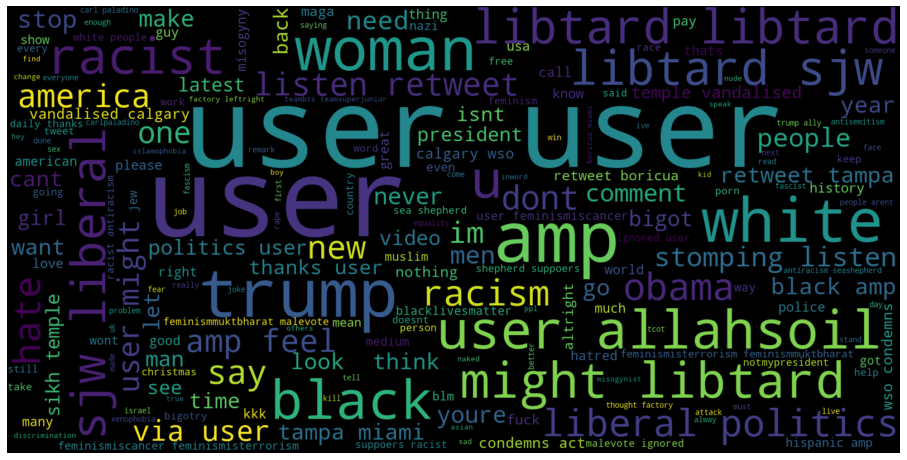

In [27]:
## Negative words
neg_tweets = df_train[df_train['label'] == 1]
neg_string = []
for t in neg_tweets.clean_tweet1:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
## split dataset
dtf_train, dtf_test = train_test_split(df_train, test_size=0.3)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

Text(0.5, 1.0, 'Sparse Matrix Sample')

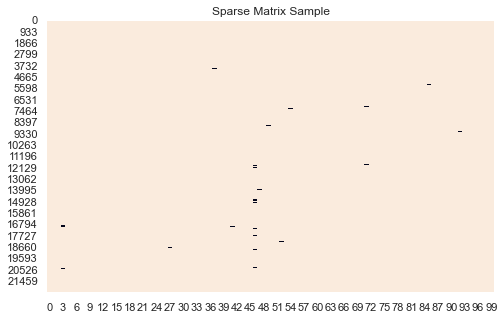

In [29]:
## Count (classic BoW)
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

corpus = dtf_train["clean_tweet1"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [30]:
X_train

<22373x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 181168 stored elements in Compressed Sparse Row format>

In [31]:
from gensim import corpora,models,similarities
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.models.word2vec import Word2Vec,Word2VecVocab

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in df_train.clean_tweet1] 
w2v_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
w2v_model.build_vocab(documents)

In [50]:
#words = w2v_model.wv.key_to_index()
vocab_size = len(w2v_model.wv)
print("Vocab size", vocab_size)

Vocab size 3238


In [51]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(5711366, 8551904)

In [52]:
w2v_model.wv.most_similar('love')

[('instamood', 0.39680686593055725),
 ('feliz', 0.37075355648994446),
 ('smile', 0.35417547821998596),
 ('lovelife', 0.35227978229522705),
 ('friendship', 0.33422935009002686),
 ('yolo', 0.33394473791122437),
 ('instadaily', 0.3270617723464966),
 ('positivity', 0.3238893151283264),
 ('mylove', 0.32018038630485535),
 ('precious', 0.31614431738853455)]

In [53]:
# Keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.clean_tweet1)
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
print(embedding_matrix.shape,tokenizer.word_index.__len__())
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    print(len(w2v_model.wv.get_vector(word)),i-1)
    # embedding_matrix[i-1] = w2v_model.wv.get_vector(word)
# print(embedding_matrix.shape)

(3238, 300) 37606
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
300 10
300 11
300 12
300 13
300 14
300 15
300 16
300 17
300 18
300 19
300 20
300 21
300 22
300 23
300 24
300 25
300 26
300 27
300 28
300 29
300 30
300 31
300 32
300 33
300 34
300 35
300 36
300 37
300 38
300 39
300 40
300 41
300 42
300 43
300 44
300 45
300 46
300 47
300 48
300 49
300 50
300 51
300 52
300 53
300 54
300 55
300 56
300 57
300 58
300 59
300 60
300 61
300 62
300 63
300 64
300 65
300 66
300 67
300 68
300 69
300 70
300 71
300 72
300 73
300 74
300 75
300 76
300 77
300 78
300 79
300 80
300 81
300 82
300 83
300 84
300 85
300 86
300 87
300 88
300 89
300 90
300 91
300 92
300 93
300 94
300 95
300 96
300 97
300 98
300 99
300 100
300 101
300 102
300 103
300 104
300 105
300 106
300 107
300 108
300 109
300 110
300 111
300 112
300 113
300 114
300 115
300 116
300 117
300 118
300 119
300 120
300 121
300 122
300 123
300 124
300 125
300 126
300 127
300 128
300 129
300 130
300 131
300 132
300 133
300 134
300 135
300 

In [58]:
if "love" in w2v_model.wv:
    print(w2v_model.wv.get_vector("love").shape)

[ 0.7842831   0.3894142  -0.0421605  -0.38633087  0.5078596   0.05252391
 -0.14741379 -0.26009327 -0.37820396  0.975972    1.1349155  -0.41390198
 -0.19129582  0.1808811   1.3104408  -0.27663994  0.18904358  0.1055597
  0.1344031   0.91160065 -0.5113578  -0.04158211  0.73447055  0.52286977
 -0.353191    0.0075496   1.278313    0.64014536  0.4535736   0.5362401
 -0.07313994  0.33699936  0.04114895 -0.5796363   0.03935355  0.22475855
  0.52487236 -0.5743221  -0.12553307 -0.1425043   0.39706624  0.20048115
  1.3396393  -0.11000931 -0.6187359  -0.47866383  0.17114773  0.086035
 -1.5691195  -0.01188735  1.1136637   0.21804033  0.07374472 -0.20591165
  0.05975453 -0.36545944 -0.36100566  0.6200639   0.2600191  -0.13087082
 -0.07654235  0.48309135  1.4797382  -0.2598016  -0.4519974  -0.45044604
  0.31433663  0.6884734   0.36961877 -0.35840997  0.5264285   0.07290907
 -0.05493754  0.5990645  -0.56962156 -0.73790467 -0.3095767   0.47393042
  0.06293042 -0.5386027  -0.14561884 -0.4983588  -0.459

In [287]:
#Bag of words
cvec = CountVectorizer()
cvec.fit(df_train.clean_tweet1)
neg_doc_matrix = cvec.transform(df_train[df_train.label == 0].clean_tweet1)
pos_doc_matrix = cvec.transform(df_train[df_train.label == 1].clean_tweet1)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
print(len(cvec.get_feature_names()))
term_freq_df.sample(10)

37624


,0,1
tremendous,1,1
flip,10,0
retweeted,10,1
thetalk,1,0
miamibeach,3,0
tiiiiiiiiiiiiiiiiiiiiiiiiiiiime,1,0
dairy,6,0
marcello,1,0
wewillnotgivein,1,0
lived,6,0


In [205]:
#TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train.clean_tweet1)
print(X.toarray())
print(len(vectorizer.get_feature_names()))

MemoryError: Unable to allocate 8.96 GiB for an array with shape (31962, 37624) and data type float64